In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import numpy as np
from PIL import Image
import os
from matplotlib import pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import OneHotEncoder
import math

## To filter warnings
import warnings
warnings.filterwarnings('ignore')


(599616,)


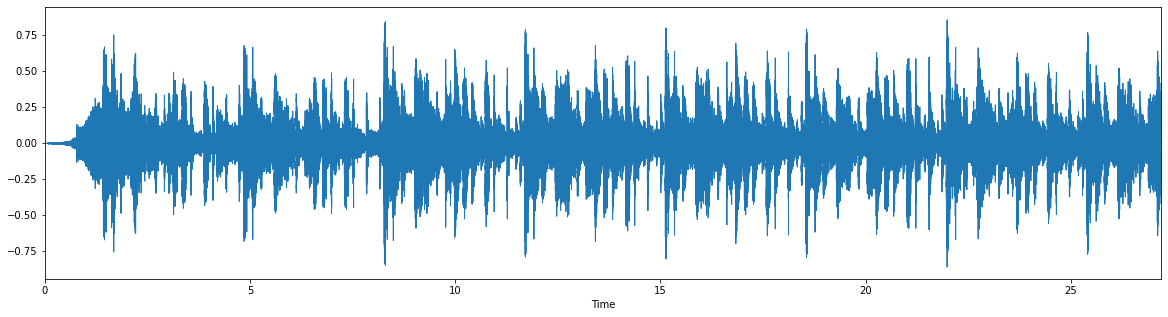

In [2]:
file_path = '/content/file_example_MP3_700KB.mp3'
x,sr = librosa.load(file_path) 
print(x.shape)
plt.figure(figsize=(20,5))                #return a time series of amplitude of audio with sampling rate sr(default=22050)
# plt.plot(range(x.shape[0]),x)
# plt.show()
librosa.display.waveplot(x,sr)

In [3]:
import IPython.display as ipd
audio = ipd.Audio(x,rate=sr)                 ## convert time series array to audio
audio

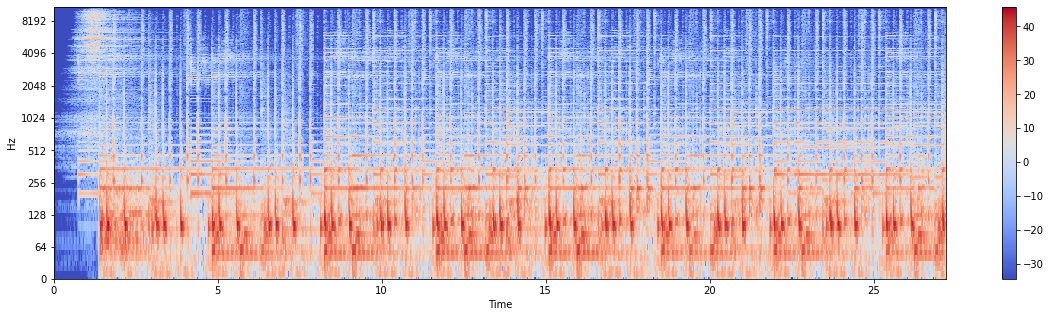

In [4]:
X = librosa.stft(x)            ##short time fourier transform of x, return a matrix where each row represent 
                               ## a time series of a particular frequency
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20,5))
librosa.display.specshow(Xdb,sr=sr,x_axis='time',y_axis='log')
plt.colorbar()

## FEATURE EXTRACTION

### 1. Zero Crossing : 
librosa.zero_crossing returns a bool matrix which returns true when there is a sign change in vlues of array(+ve to -ve or vice versa).

In [5]:
zero_x = librosa.zero_crossings(x,pad = False)

In [6]:
sum(zero_x)


38005

### 2. SPECTRAL CENTROID:
The spectral centroid indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:

                         fc=∑kS(k)f(k)∑kS(k)
 
  where  S(k)  is the spectral magnitude at frequency bin  k,  f(k)  is  the frequency at bin  k .




In [7]:
spec_cent  = librosa.feature.spectral_centroid(x+0.01)[0]       #returns a (1,t) shape matrix so [0] applied at last to make a 1D array

## IMP : 0.01 is added to shift the mean to zero frequency when there is silence 
## such that high background frequencies do not contribute much to mean

In [8]:
spec_cent.shape                ## gives the no of frames, frames are collection of samples
                               ## so as to calculate stft considering a audio to be contant for that frame

(1172,)

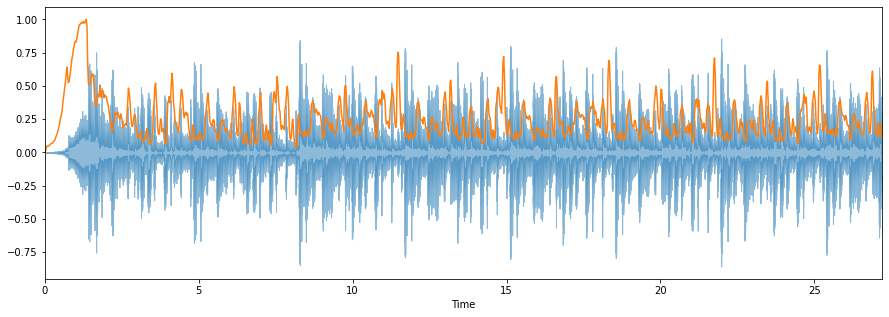

In [9]:
import sklearn
normalized_cent = sklearn.preprocessing.minmax_scale(spec_cent)        # scaling spectral_centroid to (0,1)
frames = range(len(normalized_cent))                                   # list of [0:frame]

t = librosa.frames_to_time(frames)                                     # calculating time at frame f--> t = (f*s)/sr s is the hop_length
## plotting waveplot and spectral_centroid simutaneoulsy. 
## NOTE: spectral centroid represents mean amplitude frequency with time while waveplot amplitude vs time
plt.figure(figsize=([15,5]))
librosa.display.waveplot(x,sr=sr,alpha=0.5)
plt.plot(t,normalized_cent)


### 3. SPECTRAL ROLLOFF:
It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. To obtain it, we have to calculate the fraction of bins in the power spectrum where 85% of its power is at lower frequencies

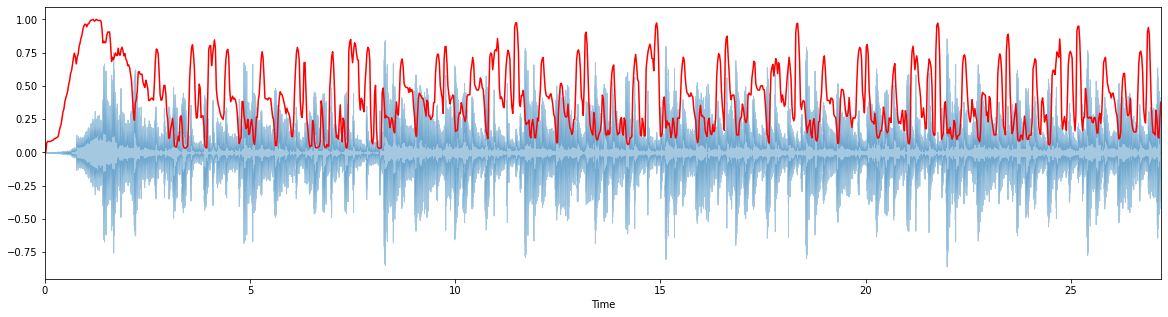

In [10]:
spec_roll = librosa.feature.spectral_rolloff(x+0.01,sr=sr)[0]
normalized_roll = sklearn.preprocessing.minmax_scale(spec_roll)
plt.figure(figsize=([20,5]))
librosa.display.waveplot(x,sr=sr,alpha=0.4)
plt.plot(t,normalized_roll,color='r')


## 4.MFCC

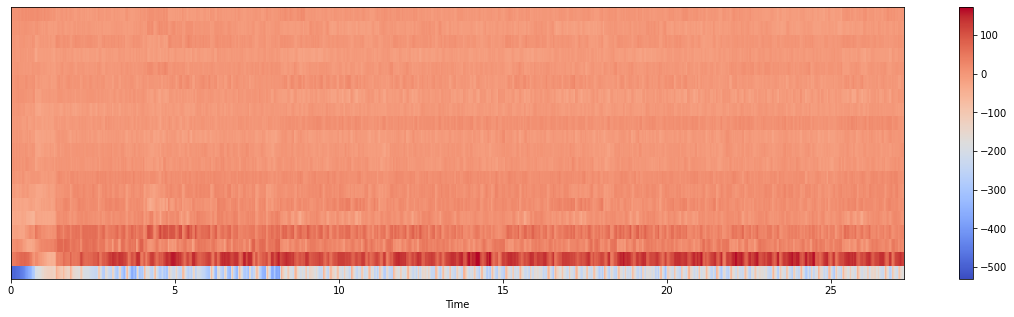

In [11]:
mfccs = librosa.feature.mfcc(x,sr=sr)
mfccs.shape
plt.figure(figsize=([20,5]))
librosa.display.specshow(mfccs,x_axis='time')
plt.colorbar()

Feature Scaling

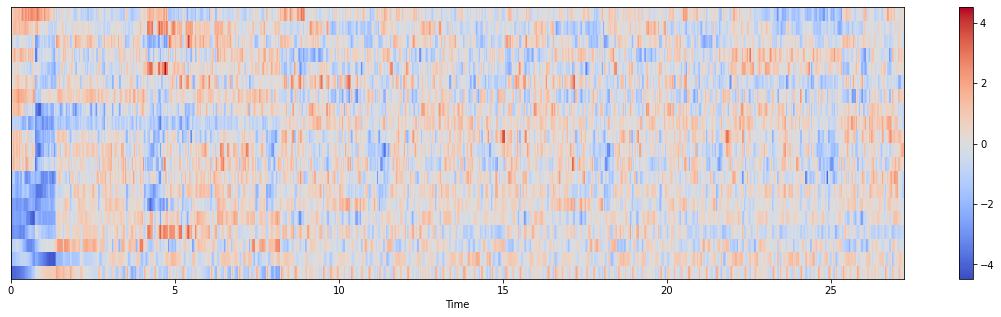

In [12]:
mfccs = sklearn.preprocessing.scale(mfccs,axis=1)
plt.figure(figsize=([20,5]))
librosa.display.specshow(mfccs,x_axis='time')
plt.colorbar()

### 5.Chroma 

(12, 1172)


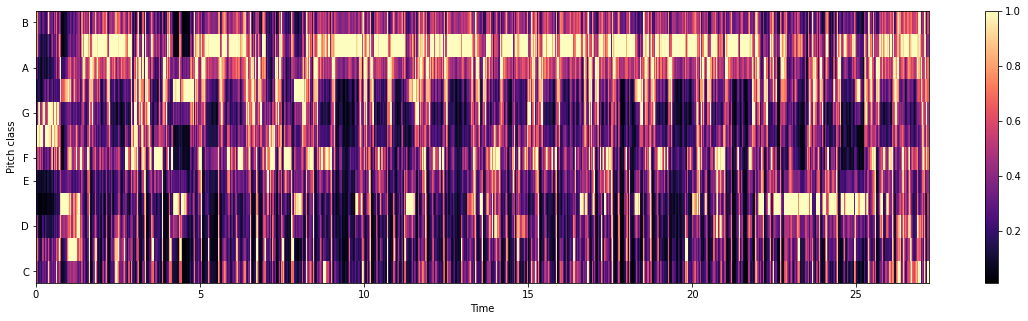

In [13]:
chromagram = librosa.feature.chroma_stft(x)
print(chromagram.shape)
plt.figure(figsize=([20,5]))
librosa.display.specshow(chromagram,x_axis='time',y_axis='chroma')
plt.colorbar()

# MLP MODEL

In [14]:
##extract features from dataset

def feature_extract(x,features,sr=22050):
  feature = np.array([])
  for i in features:
    if i=='mfcc':
      mfccs = librosa.feature.mfcc(x,sr=sr )
      feature = np.concatenate((feature,np.mean(mfccs.T,axis=0)),axis=0)
    if i=='chroma':
      chroma = librosa.feature.chroma_stft(x,sr=sr)
      feature = np.concatenate((feature,np.mean(chroma.T,axis=0)),axis=0)
    if i=='mel':
      mel_spec = librosa.feature.melspectrogram(x)
      feature = np.concatenate((feature,np.mean(mel_spec.T,axis=0)),axis=0)
    
    
  return feature

In [15]:
##Plotting the losses and accuracy
def plot_history(history):
  plt.figure()
  plt.plot(history.history['loss'],label='train_loss')
  plt.plot(history.history['val_loss'],label='test_loss')
  plt.xlabel('iterations')
  plt.ylabel('losses')
  plt.legend()
  plt.figure()
  plt.plot(history.history['accuracy'],label='train_accuracy')
  plt.plot(history.history['val_accuracy'],label='test_accuracy')
  plt.xlabel('iterations')
  plt.ylabel('accuracy')
  plt.legend()

Loading Dataset

In [16]:

## loading dataset 
#features =['mel','mfcc','chroma'] (default)

def load_dataset(type='emotion',features =['mel','mfcc','chroma'],train_size=0.8):                     
  dir = '/content/drive/MyDrive/Speech_dataset'
  X = []
  Y = []
  for i in os.listdir(dir):
    x,sr = librosa.load(dir+'/'+i)
    feature = feature_extract(x,features)
    X.append(feature)
    if type =='emotion':                                 ##classification on the basis of emotions
      y = int(i.split('-')[2][1])
      Y.append(y)
    else:
      y = np.array([((int(i.split('-')[6][1]))%2)])      ##on basis of gender
      Y.append(y)
  X = np.array(X)
  X = sklearn.preprocessing.scale(X)                     #standardizing data
  Y = np.array(Y).reshape(-1,1)
  encoder = OneHotEncoder()
  Y = encoder.fit_transform(Y).toarray()
  XY = np.hstack((X,Y))
  np.random.shuffle(XY)                                 #shuffling randomly
  X = XY[:,:XY.shape[1]-Y.shape[1]]
  Y = XY[:,(XY.shape[1]-Y.shape[1]):]
  x_train = X[:math.ceil(train_size*len(X))]
  y_train = Y[:math.ceil(train_size*len(X))]
  x_test  = X[math.ceil(train_size*len(X)):]
  y_test = Y[math.ceil(train_size*len(X)):]

  return x_train,y_train,x_test,y_test

In [21]:
#loading processed data
xg_train,yg_train,xg_test,yg_test = load_dataset(type='gender')    #features =['mel','mfcc','chroma'] (default)         
xe_train,ye_train,xe_test,ye_test = load_dataset(type='emotion')   #features =['mel','mfcc','chroma'] (default)

In [22]:
## building model with tf(n_layer1 =100,n_layer2 =75, n_layer3 =40, n_layer4 =20 )
def model(x_train,y_train,x_test,y_test):
  model = tf.keras.Sequential()
  model.add(layers.Dense(120,input_shape = (x_train.shape[1],),activation = 'relu',))
  model.add(layers.Dense(80,activation = 'relu',))
  model.add(layers.Dense(50,activation = 'relu',))
  model.add(layers.Dense(20,activation = 'relu',))
  model.add(layers.Dense(y_train.shape[1],activation='softmax'))

  optimizer = tf.optimizers.Adam(lr=0.0002)
  model.compile(optimizer=optimizer,loss = 'categorical_crossentropy',metrics=['accuracy'])
  history = model.fit(x_train,y_train,batch_size=256,epochs = 1000,verbose=1,validation_data=(x_test,y_test))

  ##plotting the history
  plot_history(history)

  #model summary and result on test_data
  print(model.summary())
  result = model.evaluate(x_test,y_test)
  print(result)
  return model

Epoch 1/1000
5/5 [==============================] - 3s 41ms/step - loss: 2.1757 - accuracy: 0.1377 - val_loss: 2.1322 - val_accuracy: 0.1558
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 2.1113 - accuracy: 0.1567 - val_loss: 2.0888 - val_accuracy: 0.1739
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 2.0647 - accuracy: 0.1857 - val_loss: 2.0587 - val_accuracy: 0.1812
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 2.0310 - accuracy: 0.2002 - val_loss: 2.0358 - val_accuracy: 0.1739
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 2.0061 - accuracy: 0.2174 - val_loss: 2.0174 - val_accuracy: 0.1775
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.9837 - accuracy: 0.2455 - val_loss: 2.0014 - val_accuracy: 0.2101
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.9653 - accuracy: 0.2545 - val_loss: 1.9868 - val_accuracy: 0.2246
Epoch 8/1000
5/5 [=

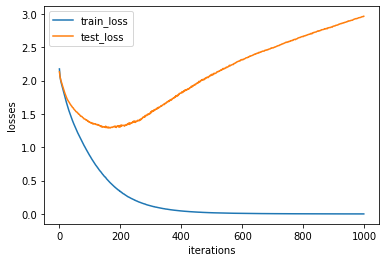

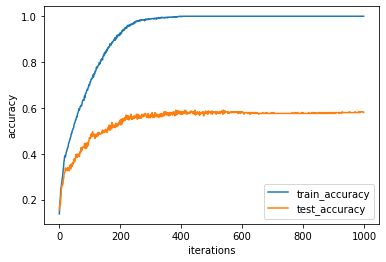

In [23]:
emotion_model = model(xe_train,ye_train,xe_test,ye_test)

Epoch 1/1000
5/5 [==============================] - 0s 33ms/step - loss: 0.6343 - accuracy: 0.6295 - val_loss: 0.5785 - val_accuracy: 0.7391
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.5604 - accuracy: 0.7790 - val_loss: 0.5243 - val_accuracy: 0.8225
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.5000 - accuracy: 0.8542 - val_loss: 0.4761 - val_accuracy: 0.8297
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.4503 - accuracy: 0.8922 - val_loss: 0.4346 - val_accuracy: 0.8551
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.4078 - accuracy: 0.9040 - val_loss: 0.3989 - val_accuracy: 0.8841
Epoch 6/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.3716 - accuracy: 0.9112 - val_loss: 0.3669 - val_accuracy: 0.8949
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.3404 - accuracy: 0.9194 - val_loss: 0.3388 - val_accuracy: 0.9022
Epoch 8/1000
5/5 [=

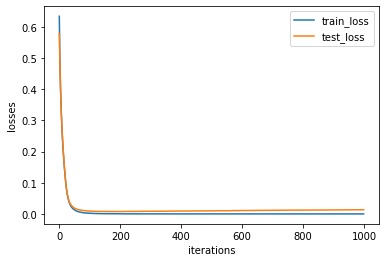

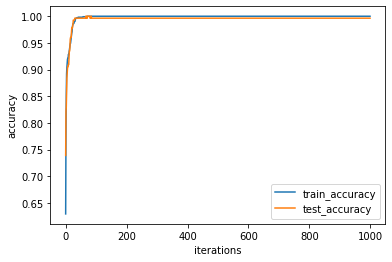

In [24]:
gender_model = model(xg_train,yg_train,xg_test,yg_test)